# Imports

In [1]:
#Necessary imports, paths, and dataset for the project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import spearmanr, pearsonr, chi2_contingency, mannwhitneyu, spearmanr, kruskal
from scipy.stats.contingency import association 
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer, RobustScaler

plt.style.use("ggplot")
sns.set_context("notebook")
pd.set_option("display.max_columns", None)

DATA_PATH = Path("../../data/raw/chronic_kindey_disease.csv")

In [2]:
%matplotlib inline

# Data Loading

In [3]:
#Load the dataset into a pandas DataFrame
df = pd.read_csv(DATA_PATH, na_values="?", skipinitialspace=True)
df.shape, df.columns

((400, 25),
 Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
        'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
        'appet', 'pe', 'ane', 'status'],
       dtype='object'))

# Data Cleaning

In [4]:
#Check for unique values in categorical columns to spot dirty data
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

rbc: [nan 'normal' 'abnormal']
pc: ['normal' 'abnormal' nan]
pcc: ['notpresent' 'present' nan]
ba: ['notpresent' 'present' nan]
htn: ['yes' 'no' nan]
dm: ['yes' 'no' '\tno' nan]
cad: ['no' 'yes' nan]
appet: ['good' 'poor' nan]
pe: ['no' 'yes' nan]
ane: ['no' 'yes' nan]
status: ['ckd' 'ckd\t' 'notckd']


In [5]:
# Cleaning - Removing potential whitespace (e.g., '\tno', ' yes')
# We found specific issues in 'dm', 'cad', and 'status' columns
cols_to_clean = ['dm', 'status']

def clean_text(x):
    if isinstance(x, str):
        return x.strip().lower()
    return x

for col in cols_to_clean:
    df[col] = df[col].apply(clean_text)

# Verify Cleaning
print("\nPost-Cleaning Unique Values")
print(f"Status: {df['status'].unique()}")


Post-Cleaning Unique Values
Status: ['ckd' 'notckd']


# Dataset without the Missing Values 

In [8]:
#Keep only complete rows (no missing values in any column)
df_modified = df.dropna().copy()

print("Original shape:", df.shape)
print("Dataset without the missing values' shape:", df_modified.shape)
print("Rows removed:", df.shape[0] - df_modified.shape[0])


Original shape: (400, 25)
Dataset without the missing values' shape: (158, 25)
Rows removed: 242


In [9]:
df_modified.isna().sum()


age       0
bp        0
sg        0
al        0
su        0
rbc       0
pc        0
pcc       0
ba        0
bgr       0
bu        0
sc        0
sod       0
pot       0
hemo      0
pcv       0
wbcc      0
rbcc      0
htn       0
dm        0
cad       0
appet     0
pe        0
ane       0
status    0
dtype: int64

# Distribution of Numerical Variables 

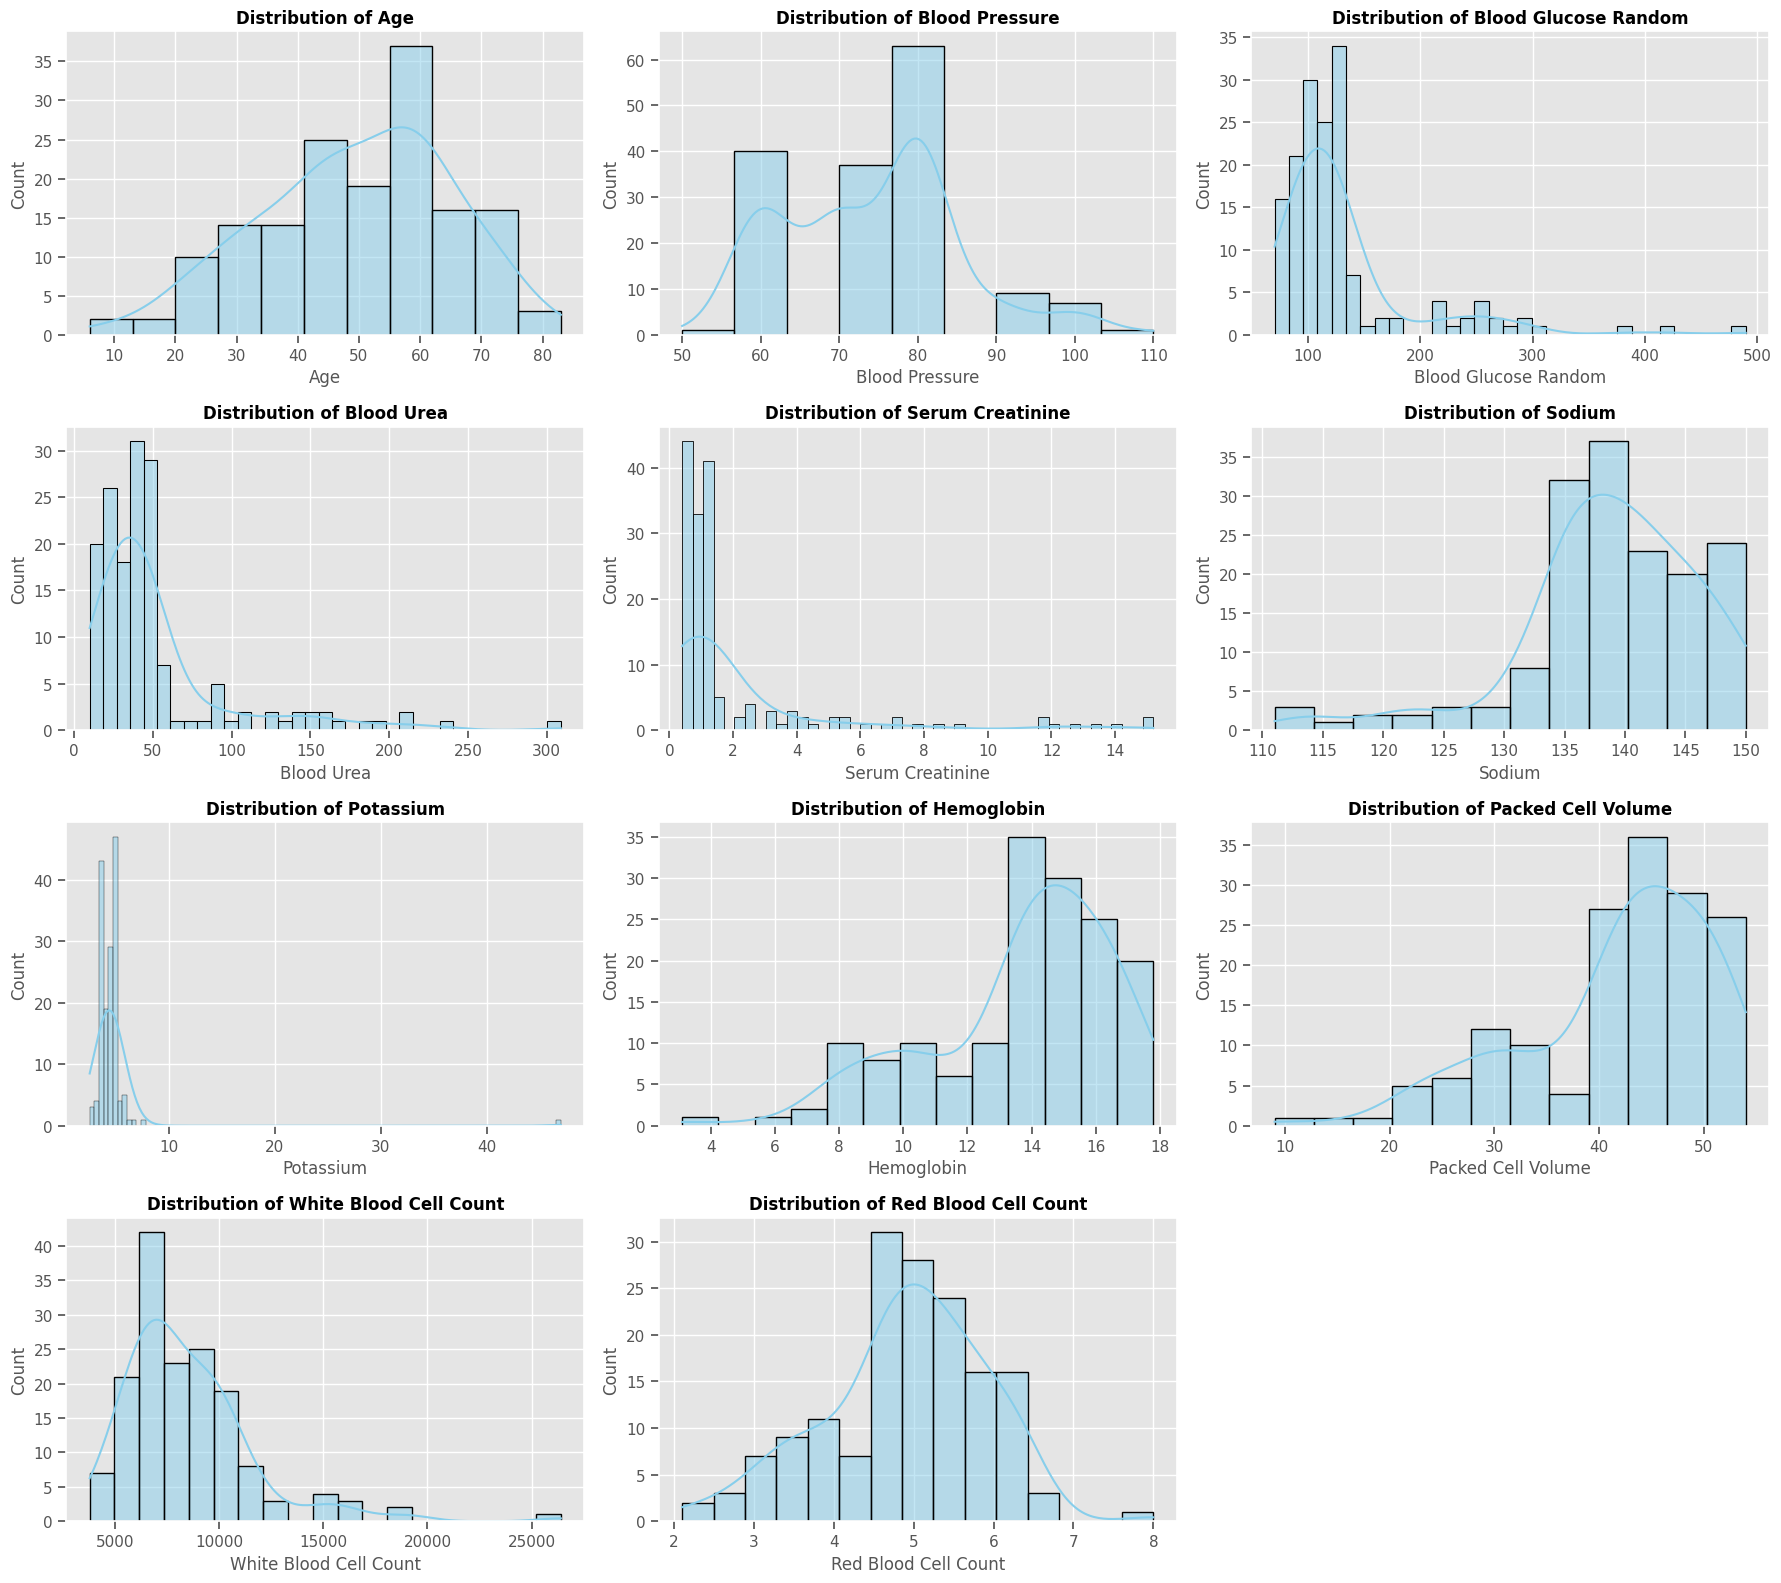

In [10]:
# Dictionary mapping column names to full names based on dataset documentation
numeric_cols_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count'
}

# Setup the plotting grid (4 rows x 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (col, full_name) in enumerate(numeric_cols_mapping.items()):
    # Plot histogram with KDE
    sns.histplot(df_modified[col].dropna(), kde=True, ax=axes[i], color='skyblue', edgecolor='black') # type: ignore

    # Set titles and labels using the full name
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(len(numeric_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Distribution of Categorical Columns

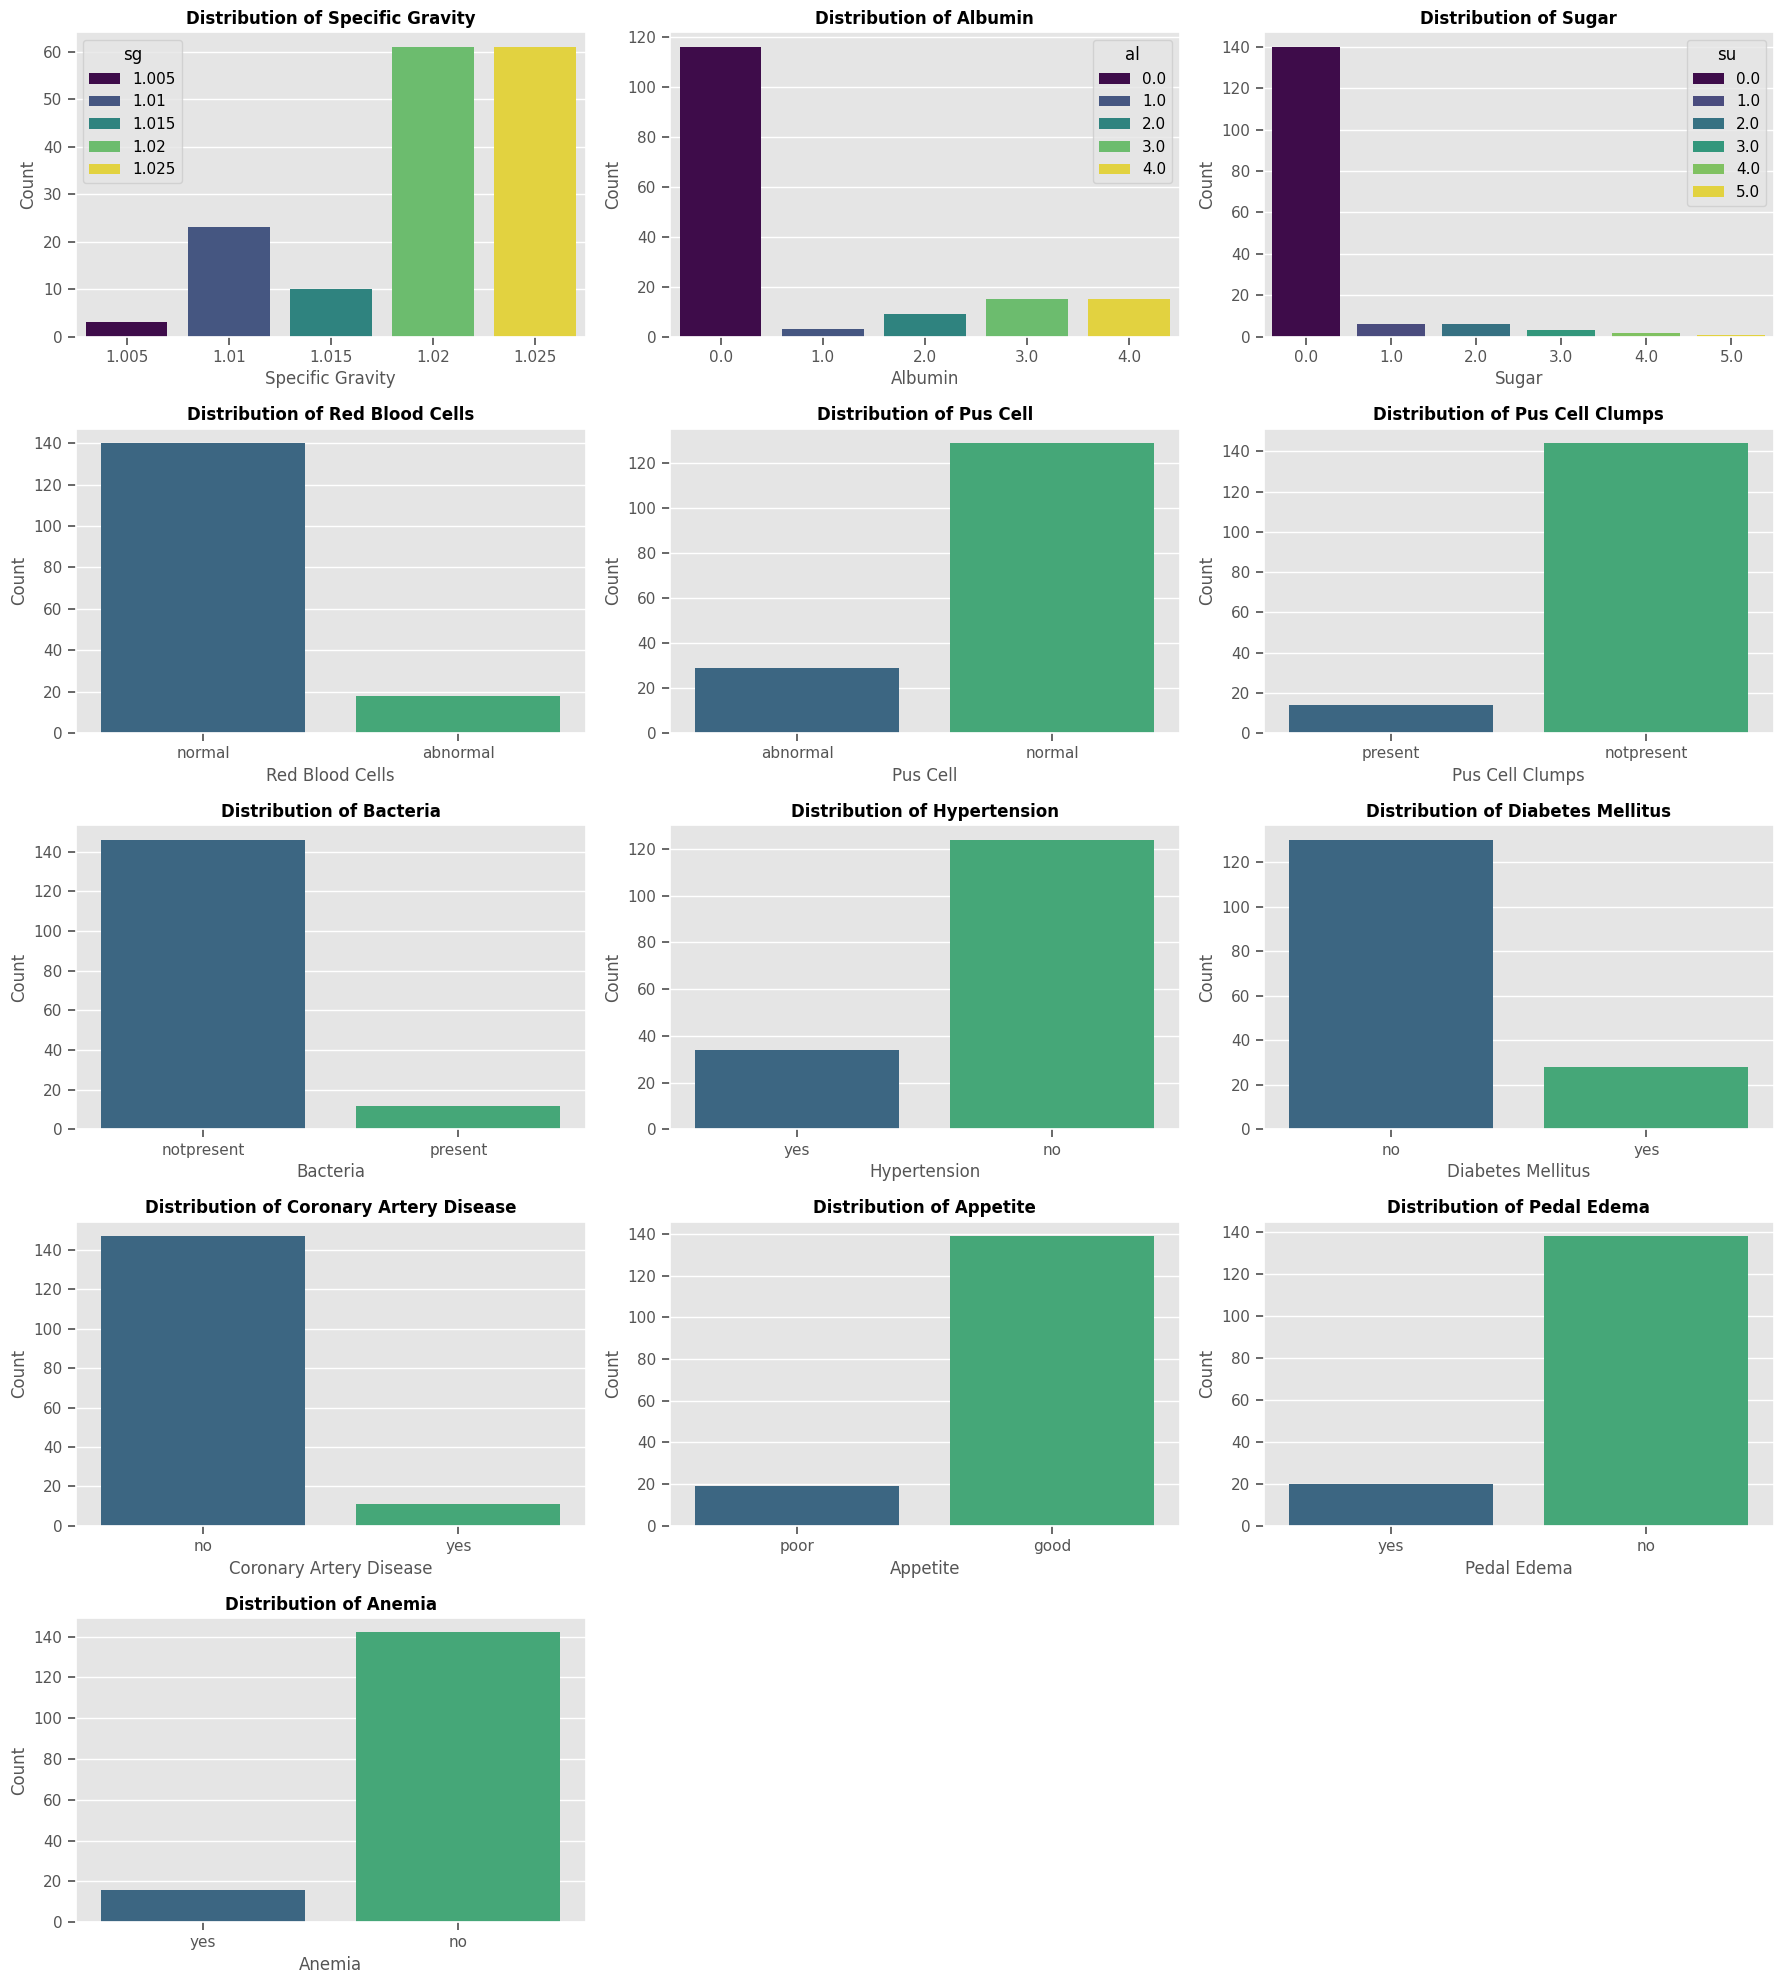

In [31]:
#Dictionary mapping categorical columns to full names
categorical_cols_mapping = {
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'pc': 'Pus Cell',
    'pcc': 'Pus Cell Clumps',
    'ba': 'Bacteria',
    'htn': 'Hypertension',
    'dm': 'Diabetes Mellitus',
    'cad': 'Coronary Artery Disease',
    'appet': 'Appetite',
    'pe': 'Pedal Edema',
    'ane': 'Anemia'
}

# Setup the plotting grid (5 rows x 3 columns)
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

for i, (col, full_name) in enumerate(categorical_cols_mapping.items()):
    # Sort order for ordinal variables (sg, al, su) to make the plot logical
    order = sorted(df_modified[col].dropna().unique()) if col in ['sg', 'al', 'su'] else None

    # Create Count Plot
    sns.countplot(x=col, data=df_modified, ax=axes[i], palette='viridis', order=order, hue= col)

    # Styling
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(len(categorical_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Distribution of the Class Column

status
notckd    115
ckd        43
Name: count, dtype: int64


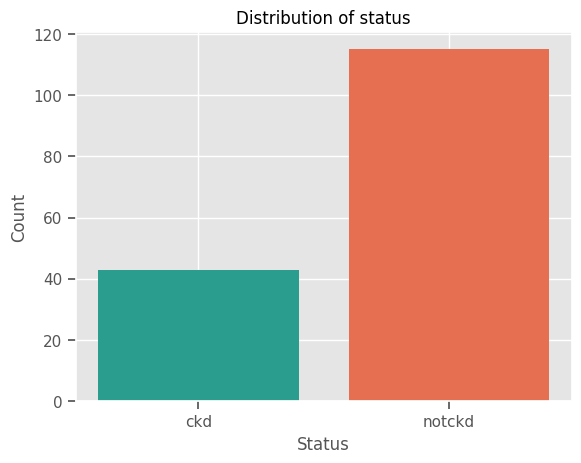

In [32]:
#Visualize the distribution of the "status" column

df_modified["status"] = df_modified["status"].astype(str).str.strip()
counts = df_modified["status"].value_counts()
print(counts)
counts = counts.reindex(["ckd", "notckd"])  # consistent order
colors = ["#2a9d8f", "#e76f51"]  # teal + coral

plt.figure()
plt.bar(counts.index, counts, color=colors)
plt.xlabel("Status")
plt.ylabel("Count")
plt.title("Distribution of status")
plt.show()

# Encoding

In [33]:
#Always work on a copy
data = df_modified.copy(deep=True)

#Let's define the nominal Columns
binary_cols = ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane"]
ordinal_cols = ["sg","al","su"] # since we have levels

#Clean whitespace/casing for string categoricals
for c in binary_cols:
    data[c] = data[c].astype("string").str.strip().str.lower()

#Binary mappings
binary_maps = {
    "rbc": {"normal": 0, "abnormal": 1},
    "pc": {"normal": 0, "abnormal": 1},
    "pcc": {"notpresent": 0, "present": 1},
    "ba": {"notpresent": 0, "present": 1},
    "htn": {"no": 0, "yes": 1},
    "dm": {"no": 0, "yes": 1},
    "cad": {"no": 0, "yes": 1},
    "appet": {"good": 0, "poor": 1},
    "pe": {"no": 0, "yes": 1},
    "ane": {"no": 0, "yes": 1},
}

for c in binary_cols:
    data[c] = data[c].map(binary_maps[c])

#Ordinal encoding for sg, al, su
#Convert to numeric safely (will make invalid strings -> NaN)
data["sg"] = pd.to_numeric(data["sg"], errors="coerce")
data["al"] = pd.to_numeric(data["al"], errors="coerce")
data["su"] = pd.to_numeric(data["su"], errors="coerce")

# Explicit order for sg (5 levels)
sg_order = [1.005, 1.010, 1.015, 1.020, 1.025]
sg_map = {v: i for i, v in enumerate(sg_order)}  # 1.005->0 ... 1.025->4
data["sg"] = data["sg"].map(sg_map)

# al and su are already ordered 0..5
data.loc[~data["al"].between(0, 5), "al"] = np.nan
data.loc[~data["su"].between(0, 5), "su"] = np.nan

### Work with a copy of the original modified dataset 

In [34]:
#df_encoded = encoded version of df 
df_encoded = data.copy(deep=True)

In [35]:
df_encoded.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,status
3,48.0,70.0,0,4.0,0.0,0,1,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,0,0,1,1,1,ckd
9,53.0,90.0,3,2.0,0.0,1,1,1,0,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,1,1,0,1,0,1,ckd
11,63.0,70.0,1,3.0,0.0,1,1,1,0,380.0,60.0,2.7,131.0,4.2,10.8,32.0,4500.0,3.8,1,1,0,1,1,0,ckd
14,68.0,80.0,1,3.0,2.0,0,1,1,1,157.0,90.0,4.1,130.0,6.4,5.6,16.0,11000.0,2.6,1,1,1,1,1,0,ckd
20,61.0,80.0,2,2.0,0.0,1,1,0,0,173.0,148.0,3.9,135.0,5.2,7.7,24.0,9200.0,3.2,1,1,1,1,1,1,ckd
22,48.0,80.0,4,4.0,0.0,0,1,0,0,95.0,163.0,7.7,136.0,3.8,9.8,32.0,6900.0,3.4,1,0,0,0,0,1,ckd
27,69.0,70.0,1,3.0,4.0,0,1,0,0,264.0,87.0,2.7,130.0,4.0,12.5,37.0,9600.0,4.1,1,1,1,0,1,0,ckd
48,73.0,70.0,0,0.0,0.0,0,0,0,0,70.0,32.0,0.9,125.0,4.0,10.0,29.0,18900.0,3.5,1,1,0,0,1,0,ckd
58,73.0,80.0,3,2.0,0.0,1,1,0,0,253.0,142.0,4.6,138.0,5.8,10.5,33.0,7200.0,4.3,1,1,1,0,0,0,ckd
71,46.0,60.0,1,1.0,0.0,0,0,0,0,163.0,92.0,3.3,141.0,4.0,9.8,28.0,14600.0,3.2,1,1,0,0,0,0,ckd


In [36]:
df_encoded[["sg"]].head(10)

,sg
3,0
9,3
11,1
14,1
20,2
22,4
27,1
48,0
58,3
71,1


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer, RobustScaler

# Start from the fully imputed + encoded dataset
df_norm = df_encoded.copy(deep=True)

# Column groups
cont_cols = ["age","bp","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc"]  # continuous numeric
ordinal_cols = ["sg","al","su"]                                                # ordered categories (keep order)
binary_cols  = ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane"]      # already 0/1

#Ensure numeric types
for c in cont_cols + ordinal_cols + binary_cols:
    df_norm[c] = pd.to_numeric(df_norm[c], errors="coerce")

#Outlier handling (continuous only)
#sodium --> treat physiologically impossible values as missing, then impute with median
df_norm.loc[df_norm["sod"] < 100, "sod"] = np.nan
df_norm["sod"] = df_norm["sod"].fillna(df_norm["sod"].median())

# potassium: clip extreme tails (robust to outliers)
pot_lo, pot_hi = df_norm["pot"].quantile(0.01), df_norm["pot"].quantile(0.99)
df_norm["pot"] = df_norm["pot"].clip(pot_lo, pot_hi)


#Transform continuous (skewed) numeric features
#Yeo–Johnson + Robust scaling
X_cont = df_norm[cont_cols].to_numpy()

pt = PowerTransformer(method="yeo-johnson", standardize=True)
X_cont_pt = pt.fit_transform(X_cont)

rs_cont = RobustScaler()
X_cont_scaled = rs_cont.fit_transform(X_cont_pt)

df_norm.loc[:, cont_cols] = X_cont_scaled


#Scale ordinal features (we'll respect order and will not power-transform)

rs_ord = RobustScaler()
df_norm.loc[:, ordinal_cols] = rs_ord.fit_transform(df_norm[ordinal_cols].to_numpy())


# Let's check the distributions again

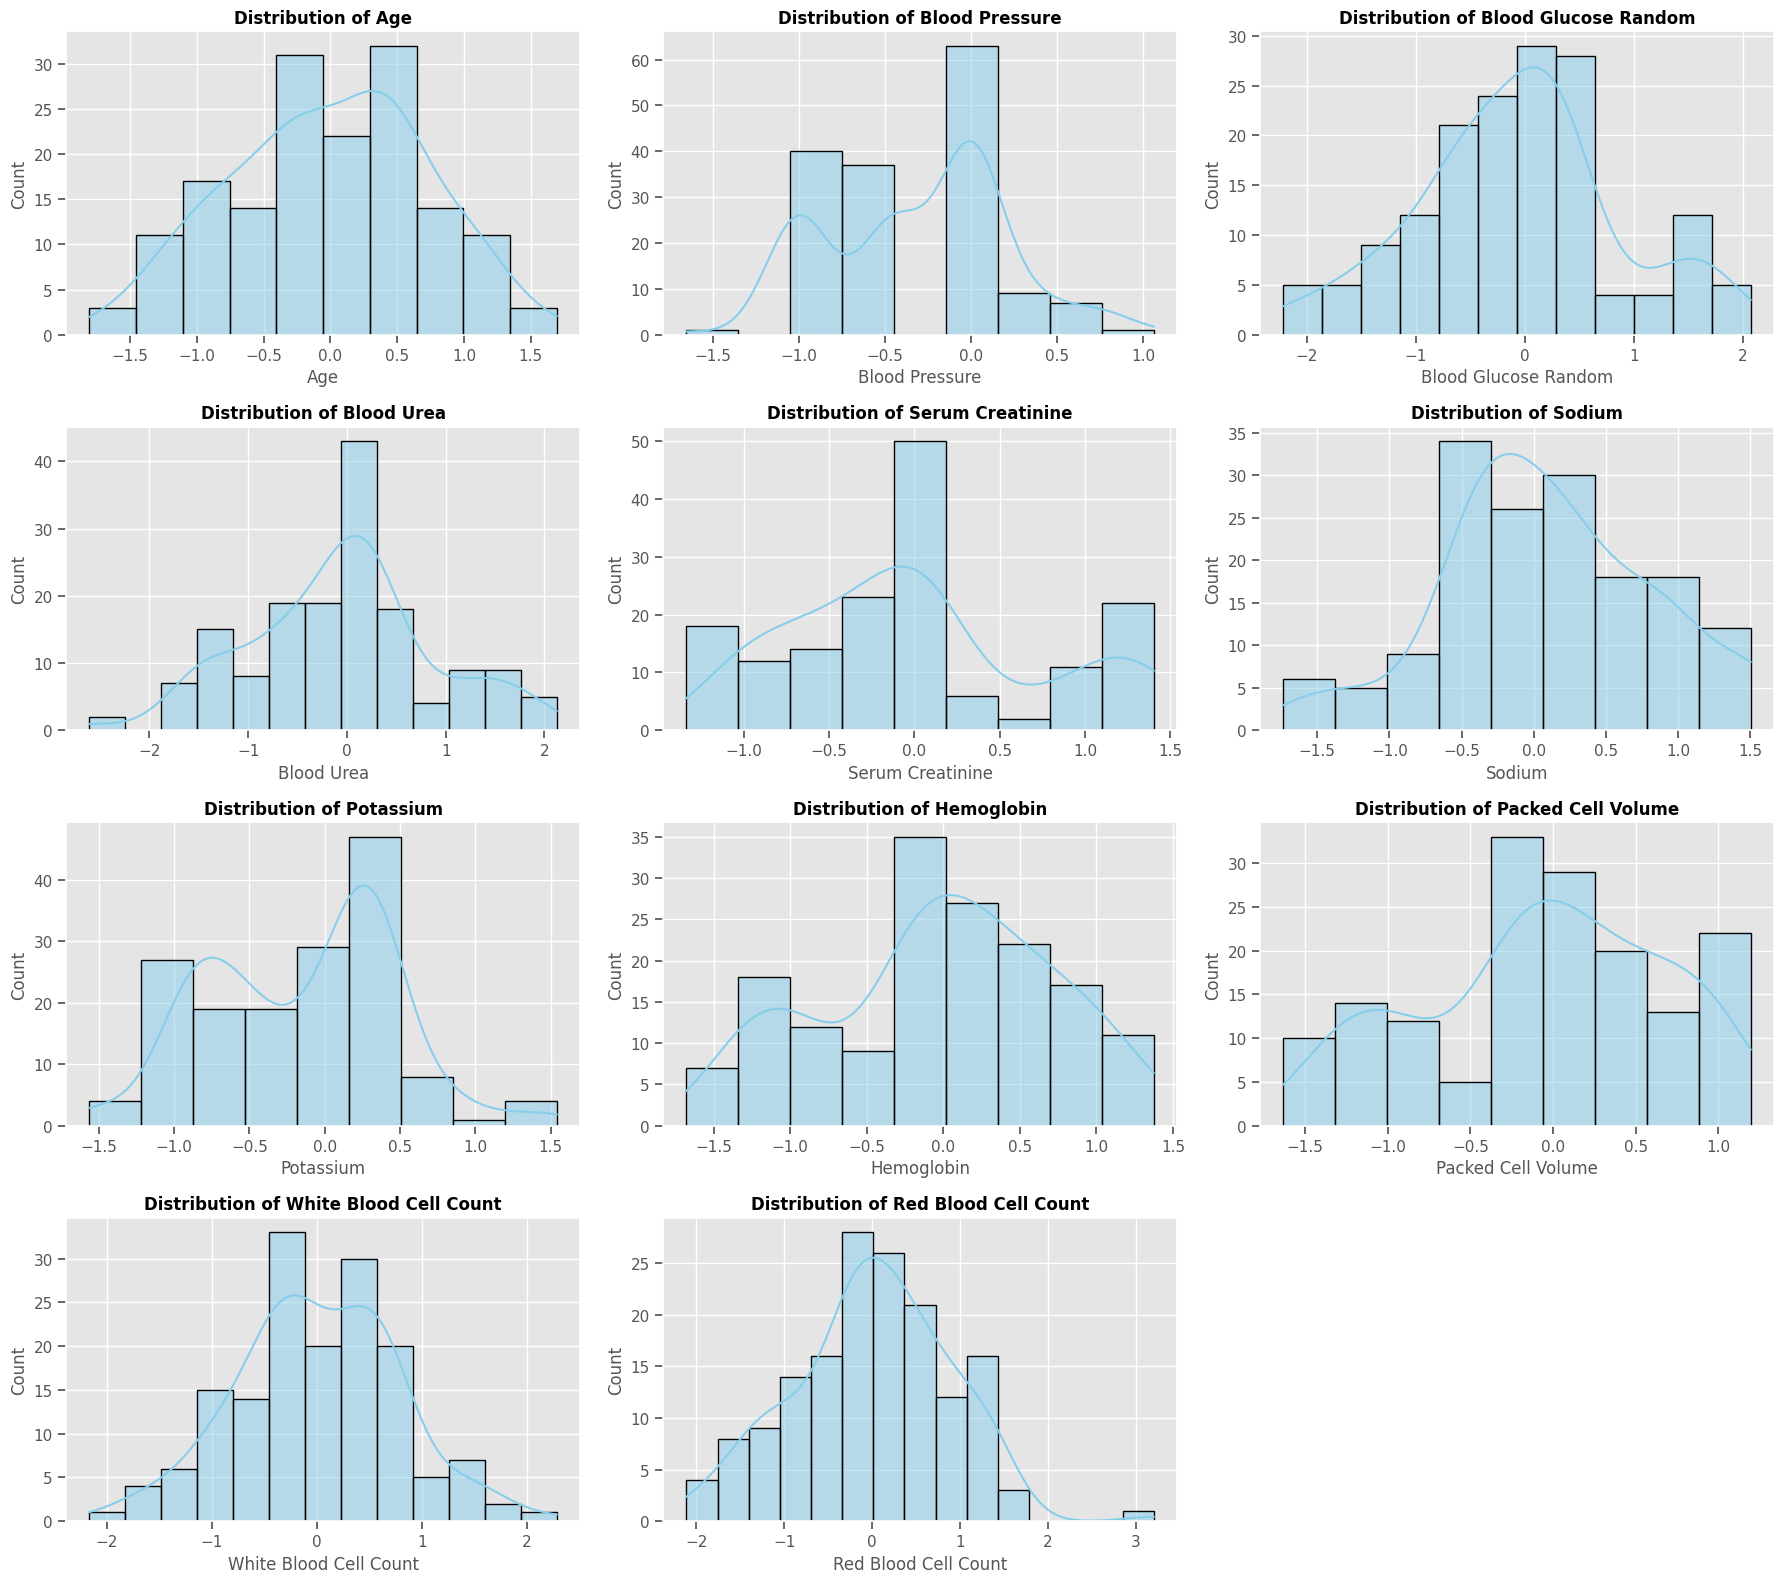

In [39]:
#Univariate Analysis 
# Dictionary mapping column names to full names based on dataset documentation
numeric_cols_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count'
}

# Setup the plotting grid (4 rows x 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (col, full_name) in enumerate(numeric_cols_mapping.items()):
    # Plot histogram with KDE
    sns.histplot(df_norm[col], kde=True, ax=axes[i], color='skyblue', edgecolor='black')

    # Set titles and labels using the full name
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(len(numeric_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

If a value is below the mean (𝑥<𝜇), then z is negative. If it’s above the mean, it’s positive.
PowerTransformer applies a nonlinear, monotonic transformation to reduce skewness and make the distribution more “Gaussian-like”.
RobustScaler make sense here because some of the numeric columns have outliers.


# Feature Engineering

In [41]:
import numpy as np
import pandas as pd

#Choose the dataset for clustering
work = df_norm.copy()

#Separate label for visualization only
y_status = work["status"].astype("string").str.strip().str.lower()

#Features only without the status
X = work.drop(columns=["status"]).copy()

#Quick Check
print("Any missing in X?", X.isna().sum().sum())
print("X shape:", X.shape)
print("Status counts:\n", y_status.value_counts(dropna=False))

Any missing in X? 0
X shape: (158, 24)
Status counts:
 status
notckd    115
ckd        43
Name: count, dtype: Int64


# Unsupervised Learning

It compresses our features into 3 PCA components and plots them in 3D, colored by CKD status, to see if the classes separate.

Explained variance ratio: [0.52361679 0.07159013 0.05769787]
Total explained (PC1+PC2+PC3): 0.6529047871690454


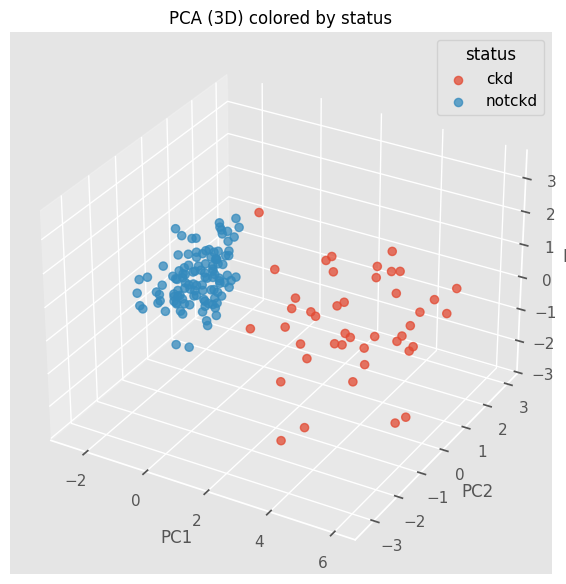

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# PCA to 3D
pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(X)

pca_df = pd.DataFrame(Z, columns=["PC1", "PC2", "PC3"])
pca_df["status"] = y_status.values

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained (PC1+PC2+PC3):", pca.explained_variance_ratio_.sum())

# 3D scatter
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# consistent colors per class
palette = sns.color_palette(n_colors=pca_df["status"].nunique())
color_map = dict(zip(sorted(pca_df["status"].unique()), palette))

for label, grp in pca_df.groupby("status"):
    ax.scatter(grp["PC1"], grp["PC2"], grp["PC3"],
               label=label, alpha=0.75, s=35, c=[color_map[label]])

ax.set_title("PCA (3D) colored by status")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(title="status")
plt.tight_layout()
plt.show()


What we did basically?

We have 24 features. Many of them move together (like urea + creatinine both go up when kidneys are worse). So there’s repeated information. Instead of 24 separate columns, PCA (Principal Component Analysis) create a few new columns that capture the main patterns.PC1,2,3 are new variables created from your original columns.Each principal component is a weighted combination of all your original numeric features.


The numeric result's interpretation:

PC1 = 0.5236 → PC1 alone captures 52.36% of the variance.
PC2 = 0.0716 → PC2 captures 7.16% more.
PC3 = 0.0577 → PC3 captures 5.77% more.
Together the the first 3 PCs capture about 65.29% of the total variance in X

Graphical Interpretation:
From the graph we can say it's a pretty good separation, mainly because the blue (notckd) points form a tight cluster on one side, while the red (ckd) points sit mostly on a different side with only a few points drifting toward the boundary. In our 3D PCA plot, the two clusters are separated mainly along PC1 (which makes sense because PC1 explains ~52% of variance). PC2/PC3 add spread but don’t change the “two clouds” story

## Kmeans --> to check (is there any structure??)

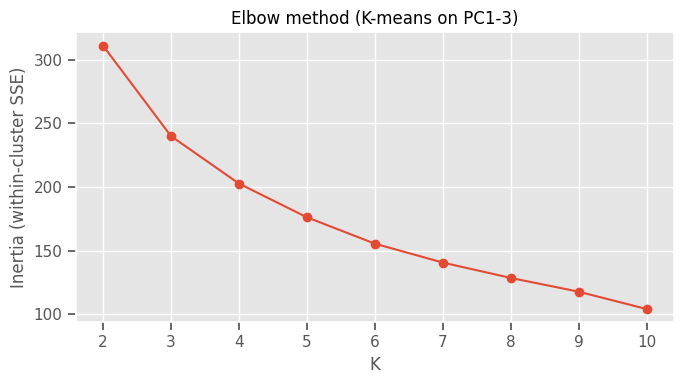

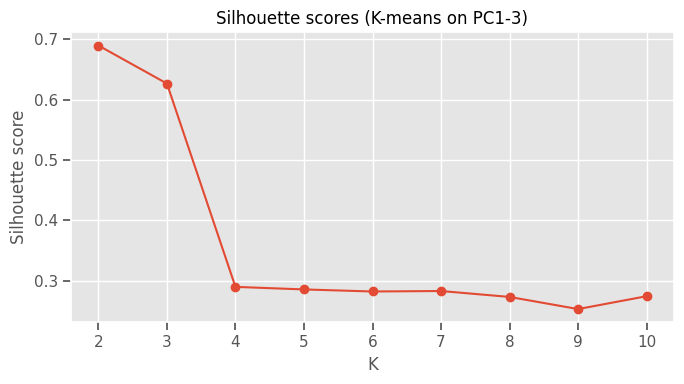

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# PCA to 3 components (reuse if you already have Z)
pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(X)

Ks = range(2, 11)
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Z)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(Z, labels))

plt.figure(figsize=(7,4))
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow method (K-means on PC1-3)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(list(Ks), sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores (K-means on PC1-3)")
plt.tight_layout()
plt.show()


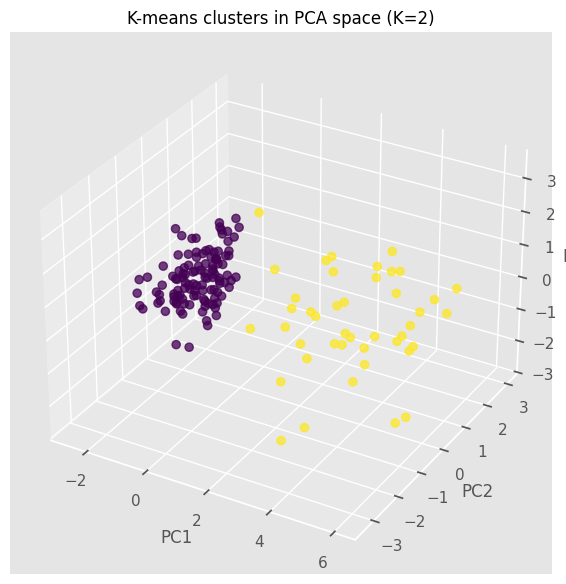

In [44]:
from mpl_toolkits.mplot3d import Axes3D

best_k = 2  # change after you inspect elbow/silhouette
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_km = km.fit_predict(Z)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c=labels_km, alpha=0.75, s=35)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title(f"K-means clusters in PCA space (K={best_k})")
plt.tight_layout()
plt.show()


## Hierarchical Clustering --> great for interpretation (dendrogram + different linkages), but it’s easier once you already have a rough idea of how many clusters might exist

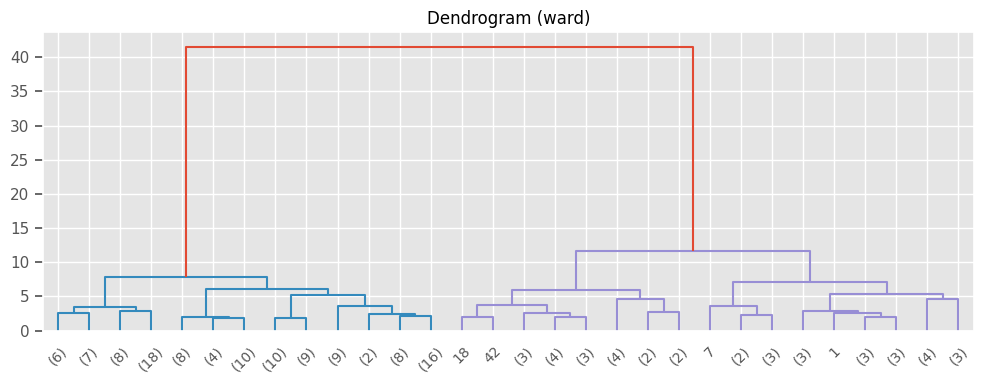

ward: silhouette=0.690


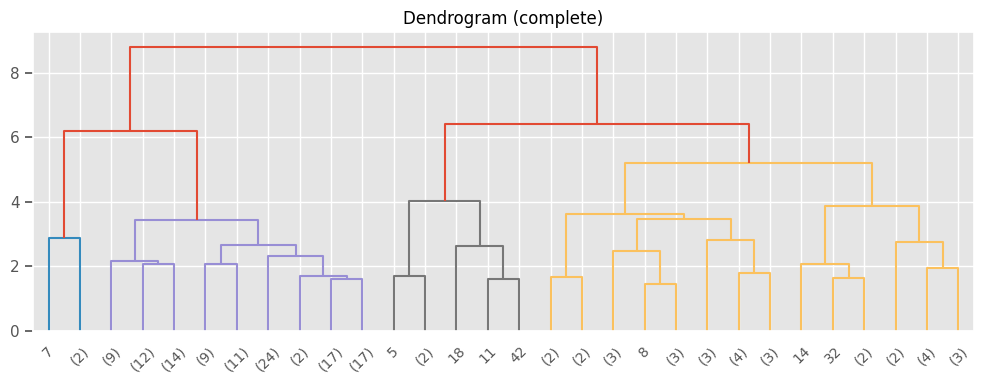

complete: silhouette=0.672


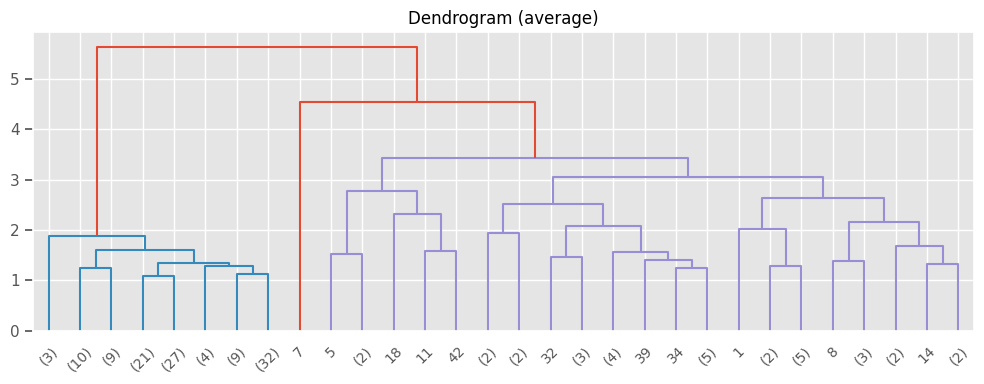

average: silhouette=0.690


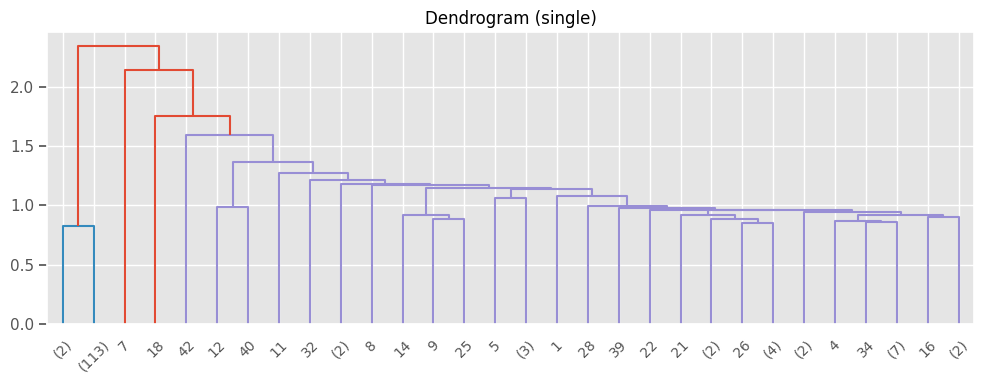

single: silhouette=0.690


In [45]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

Z_link = Z  # use PCA space for clarity

linkages = ["ward", "complete", "average", "single"]

for method in linkages:
    L = linkage(Z_link, method=method)
    plt.figure(figsize=(10,4))
    dendrogram(L, truncate_mode="lastp", p=30)
    plt.title(f"Dendrogram ({method})")
    plt.tight_layout()
    plt.show()

    # cut into K clusters (use your chosen K)
    labels_h = fcluster(L, t=best_k, criterion="maxclust") - 1
    sil = silhouette_score(Z_link, labels_h)
    print(f"{method}: silhouette={sil:.3f}")


In [46]:
import pandas as pd

ct = pd.crosstab(labels_km, y_status, rownames=["cluster"], colnames=["status"])
print(ct)
print(ct.div(ct.sum(axis=1), axis=0))  # row-normalized proportions


status   ckd  notckd
cluster             
0          0     115
1         43       0
status   ckd  notckd
cluster             
0        0.0     1.0
1        1.0     0.0


In [25]:
print("status" in X.columns)          #should be False
print(X.shape, y_status.shape)


False
(158, 24) (158,)


Results:

From the K-means (silhouette plot), our data (in PC1–PC3 space) naturally looks like two clusters (best k=2). From the Elbow plot, Inertia keeps going down as K increases (it always does), but the biggest “useful” improvement is early (around K=2 or K=3). The best k we end up choosing is K=2.

Our crosstable showed Cluster 0: 115 notckd, 0 ckd and Cluster 1: 43 ckd, 0 notckd which basically means in this subset which we have used, clustering separated the classes 100% correctly.

Our Hierarchical clustering agrees with K means. The “two-group structure” is so strong that the linkage choice barely matters (the silhouette scores for different linkages are: single ≈ 0.690,average ≈ 0.690,ward ≈ 0.690). Complete linkage is a bit less aligned(complete ≈ 0.672 which is slightly worse)


On the complete-case subset (n=158), the data forms two very distinct clusters that align perfectly with CKD status.


Other steps we can follow at this point:

In [47]:
#Confirm no leakage (make sure status isn’t in X).

df_check = df_modified.copy()
df_check["cluster"] = labels_km  # your kmeans labels on the same rows

summary = df_check.groupby("cluster")[["bu","sc","hemo","pcv","rbcc","wbcc","bgr","sod","pot","bp","age"]].mean()
print(summary)


                 bu        sc       hemo        pcv      rbcc          wbcc  \
cluster                                                                       
0         33.000000  0.871304  15.152174  46.513043  5.339130   7699.130435   
1        104.930233  5.711628   9.769767  29.627907  3.695349  10553.488372   

                bgr         sod       pot         bp        age  
cluster                                                          
0        107.939130  141.773913  4.311304  71.826087  46.678261  
1        193.930233  131.023256  5.506977  80.000000  57.279070  


Our unsupervised clustering (K-means / hierarchical) identifies two distinct patient groups. Cluster 0 shows near-normal renal function (low urea and creatinine) and normal hematology values (higher hemoglobin, PCV, and RBC count), suggesting a healthier/non-CKD profile. Cluster 1 shows a classic CKD-like clinical pattern, markedly elevated urea and creatinine, lower hemoglobin and PCV (anemia), higher potassium, lower sodium, higher glucose, and older age. These strong biochemical differences explain the clear separation in PCA space and the high silhouette score, and they also explain why K=2 is the most natural cluster solution.

### F1 SCORE --> Which linkage gives clusters that best align with ckd/notckd?”

F1 score tells us how well our model is balancing “catching the positives” and “not making too many false alarms.” It’s mainly used when classes are imbalanced. 

- F1 = 1.0 → perfect (no FP and no FN)
- F1 ≈ 0 → terrible

Higher is better, but “good” depends on the problem


In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA

#true labels (make sure y_true is 0/1)
y_true = (df_modified["status"].str.strip().str.lower() == "ckd").astype(int).values

#PCA space you clustered on (PC1-3)
# If you already have Z from PCA, reuse it; otherwise:
pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(X)   # X must be your preprocessed feature matrix (no status)

def best_f1_against_truth(y_true, y_pred01):
    f1_a = f1_score(y_true, y_pred01)
    f1_b = f1_score(y_true, 1 - y_pred01)   # flipped labels
    if f1_b > f1_a:
        return f1_b, True
    return f1_a, False

results = []

for method in ["single", "average", "complete", "ward"]:
    L = linkage(Z, method=method)
    labels = fcluster(L, t=2, criterion="maxclust") - 1  # -> 0/1
    f1, flipped = best_f1_against_truth(y_true, labels)

    results.append({
        "linkage": method,
        "F1 (best mapping)": f1,
        
    })

pd.DataFrame(results).sort_values("F1 (best mapping)")


,linkage,F1 (best mapping)
2,complete,0.963855
0,single,1.000000
1,average,1.000000
3,ward,1.000000


F1 score per feature” (feature ranking) using 1-feature models

# Numeric features: 1-feature logistic regression (cross-validated F1) --> Which single feature is most predictive of CKD by itself?

In [51]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

y_true = (df_modified["status"].str.strip().str.lower() == "ckd").astype(int).values

numeric_cols = ["age","bp","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for col in numeric_cols:
    X1 = df_modified[[col]].copy()

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000))
    ])

    f1 = cross_val_score(pipe, X1, y_true, cv=cv, scoring="f1").mean()
    rows.append((col, f1))

feat_rank_num = pd.DataFrame(rows, columns=["feature", "cv_F1"]).sort_values("cv_F1", ascending=False)
feat_rank_num


,feature,cv_F1
7,hemo,0.938039
8,pcv,0.922801
10,rbcc,0.896667
4,sc,0.835952
3,bu,0.750769
2,bgr,0.692601
5,sod,0.685501
9,wbcc,0.424675
1,bp,0.337172
0,age,0.070769


# Categorical features: one-hot + logistic regression

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = [c for c in df_modified.columns if c not in numeric_cols + ["status"]]

rows = []
for col in cat_cols:
    X1 = df_modified[[col]].copy()

    pre = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), [col])
    ])

    pipe = Pipeline([
        ("pre", pre),
        ("lr", LogisticRegression(max_iter=2000))
    ])

    f1 = cross_val_score(pipe, X1, y_true, cv=cv, scoring="f1").mean()
    rows.append((col, f1))

feat_rank_cat = pd.DataFrame(rows, columns=["feature", "cv_F1"]).sort_values("cv_F1", ascending=False)
feat_rank_cat


,feature,cv_F1
1,al,0.988235
0,sg,0.909566
7,htn,0.881429
4,pc,0.799029
8,dm,0.788132
11,pe,0.630769
10,appet,0.604762
2,su,0.586014
3,rbc,0.569138
12,ane,0.538228


Depending on linkages”: best features that explain each linkage’s clusters --> “for each linkage, which features best separate the clusters it produces?”

In [53]:
from sklearn.metrics import f1_score

def best_f1_binary(a, b):
    # a is true 0/1, b is pred 0/1 but can be flipped
    return max(f1_score(a, b), f1_score(a, 1-b))

linkage_feature_best = {}

for method in ["single", "average", "complete", "ward"]:
    L = linkage(Z, method=method)
    cl = fcluster(L, t=2, criterion="maxclust") - 1  # 0/1

    scores = []
    for col in numeric_cols:
        # simple threshold rule: compare feature to median, yields 0/1
        x = df_modified[col].values
        pred = (x > np.nanmedian(x)).astype(int)
        scores.append((col, best_f1_binary(cl, pred)))

    linkage_feature_best[method] = sorted(scores, key=lambda t: t[1], reverse=True)[:5]

linkage_feature_best


{'single': [('sc', 0.7454545454545455),
  ('hemo', 0.6885245901639344),
  ('rbcc', 0.6721311475409836),
  ('pcv', 0.65625),
  ('sod', 0.6341463414634146)],
 'average': [('sc', 0.7454545454545455),
  ('hemo', 0.6885245901639344),
  ('rbcc', 0.6721311475409836),
  ('pcv', 0.65625),
  ('sod', 0.6341463414634146)],
 'complete': [('sc', 0.7476635514018691),
  ('hemo', 0.6554621848739496),
  ('rbcc', 0.6386554621848739),
  ('pcv', 0.624),
  ('bu', 0.6050420168067226)],
 'ward': [('sc', 0.7454545454545455),
  ('hemo', 0.6885245901639344),
  ('rbcc', 0.6721311475409836),
  ('pcv', 0.65625),
  ('sod', 0.6341463414634146)]}

# Logistic regression

In [54]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# X and y
X_all = df_modified.drop(columns=["status"])
y = (df_modified["status"].str.strip().str.lower() == "ckd").astype(int)

# detect column types
num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_all.select_dtypes(include=["object"]).columns.tolist()

print("Numeric cols:", len(num_cols), num_cols)
print("Categorical cols:", len(cat_cols), cat_cols)
print("X_all shape:", X_all.shape, "y distribution:", y.value_counts().to_dict())


Numeric cols: 14 ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
Categorical cols: 10 ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
X_all shape: (158, 24) y distribution: {0: 115, 1: 43}


In [55]:
from sklearn.linear_model import LogisticRegression

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

pipe_l1 = Pipeline([
    ("pre", preprocess),
    ("lr", LogisticRegression(penalty="l1", solver="liblinear", max_iter=5000))
])

pipe_l1.fit(X_all, y)

# get feature names after preprocessing
feature_names = pipe_l1.named_steps["pre"].get_feature_names_out()
coefs = pipe_l1.named_steps["lr"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

# show top features by absolute coefficient (importance)
top = coef_df.sort_values("abs_coef", ascending=False).head(20)
print("\nTop 20 features (L1 Logistic Regression):")
print(top[["feature", "coef"]].to_string(index=False))

# show which features were kept (non-zero)
selected = coef_df[coef_df["coef"] != 0].sort_values("abs_coef", ascending=False)
print("\nNumber of selected (non-zero) features:", selected.shape[0])
print(selected[["feature", "coef"]].head(30).to_string(index=False))




Top 20 features (L1 Logistic Regression):
          feature      coef
          num__al  2.893425
       cat__dm_no -1.166837
      cat__htn_no -0.777609
          num__sg -0.737350
        num__hemo -0.649579
         num__pcv -0.634727
        num__wbcc  0.154701
         num__bgr  0.040580
        num__rbcc -0.036921
         num__age  0.000000
          num__bp  0.000000
         num__sod  0.000000
         num__pot  0.000000
          num__bu  0.000000
cat__rbc_abnormal  0.000000
  cat__rbc_normal  0.000000
          num__sc  0.000000
          num__su  0.000000
   cat__pc_normal  0.000000
 cat__pc_abnormal  0.000000

Number of selected (non-zero) features: 9
    feature      coef
    num__al  2.893425
 cat__dm_no -1.166837
cat__htn_no -0.777609
    num__sg -0.737350
  num__hemo -0.649579
   num__pcv -0.634727
  num__wbcc  0.154701
   num__bgr  0.040580
  num__rbcc -0.036921


num__al +2.88 is huge → albumin is strongly associated with CKD.
dm_no -1.08 strongly reduces CKD odds.
htn_no -0.87 reduces CKD odds.
sg -0.73 (higher specific gravity may align with healthier kidney function in this dataset).
hemo, pcv negatives match anemia pattern

Our model is basically saying CKD is explained mostly by:
Albumin (AL) ↑
Diabetes and hypertension status (No → notCKD)
Kidney function / urine concentration via SG
Anemia markers (hemo, pcv)
Everything else adds only small extra information.

This also matches our cluster-mean story (CKD cluster had worse renal markers + anemia).

In [44]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("pre", preprocess),
    ("lr", LogisticRegression(penalty="l1", solver="liblinear", max_iter=5000))
])

param_grid = {"lr__C": [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring="f1", cv=cv)
grid.fit(X_all, y)

print("Best C:", grid.best_params_)
print("Best CV F1:", grid.best_score_)


Best C: {'lr__C': 0.5}
Best CV F1: 0.9882352941176471


In [ ]:
# here we changed the c

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

pipe_l1 = Pipeline([
    ("pre", preprocess),
    ("lr", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=0.5,              
        max_iter=5000,
        random_state=42
    ))
])

pipe_l1.fit(X_all, y)

# feature names after preprocessing
feature_names = pipe_l1.named_steps["pre"].get_feature_names_out()
coefs = pipe_l1.named_steps["lr"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

top = coef_df.sort_values("abs_coef", ascending=False).head(20)
print("\nTop 20 features (L1 Logistic Regression, C=0.5):")
print(top[["feature", "coef"]].to_string(index=False))

selected = coef_df[coef_df["coef"] != 0].sort_values("abs_coef", ascending=False)
print("\nNumber of selected (non-zero) features:", selected.shape[0])
print(selected[["feature", "coef"]].head(30).to_string(index=False))



Top 20 features (L1 Logistic Regression, C=0.5):
          feature      coef
          num__al  2.407501
       cat__dm_no -0.873275
      cat__htn_no -0.818630
          num__sg -0.619361
        num__hemo -0.558513
         num__pcv -0.531465
        num__wbcc  0.055143
         num__age  0.000000
          num__bp  0.000000
          num__bu  0.000000
         num__pot  0.000000
         num__sod  0.000000
          num__sc  0.000000
        num__rbcc  0.000000
cat__rbc_abnormal  0.000000
  cat__rbc_normal  0.000000
          num__su  0.000000
         num__bgr  0.000000
   cat__pc_normal  0.000000
 cat__pc_abnormal  0.000000

Number of selected (non-zero) features: 7
    feature      coef
    num__al  2.407501
 cat__dm_no -0.873275
cat__htn_no -0.818630
    num__sg -0.619361
  num__hemo -0.558513
   num__pcv -0.531465
  num__wbcc  0.055143


# Best Features Analysis 


We will use df_norm (normalised and scaled dataset) where continuous numeric variables are transformed + scaled, ordinal variables keep their order and are scaled and binary variables are 0/1. 

Since we need an unbiased estimate of how well the chosen features generalize, we will split into train and test. Stratify keeps the CKD/notCKD ratio similar in both sets, so the evaluation is fair. Feature selection can overfit if we “peek” at the whole dataset. Splitting early helps avoid that.




In [56]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

target_col = "status"

X = df_norm.drop(columns=[target_col]).copy()
y = df_norm[target_col].copy()

# If y is string labels, encode to 0/1 for some methods
if y.dtype == "object" or str(y.dtype).startswith("string"):
    y = LabelEncoder().fit_transform(y)

feature_names = X.columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Mutual Information (It's pretty fast)
MI measures how much information a feature gives you about the target, including non-linear relationships. CKD patterns are not always linear (e.g., interactions between renal markers, electrolytes, anemia markers).MI is a strong first-pass method because it doesn’t assume normality or linearity.

In [57]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame({"feature": feature_names, "mi": mi}).sort_values("mi", ascending=False)

print("Top 20 by Mutual Information:")
print(mi_df.head(20).to_string(index=False))

Top 20 by Mutual Information:
feature       mi
   hemo 0.560670
    pcv 0.555814
     al 0.535340
     sc 0.529752
   rbcc 0.529384
     bu 0.457329
     sg 0.411016
    htn 0.383912
     dm 0.322194
     pc 0.293746
    sod 0.276154
    rbc 0.242472
    bgr 0.239499
  appet 0.232966
     pe 0.195202
    ane 0.163860
    cad 0.156747
     su 0.150582
     bp 0.140336
    pcc 0.114944


# ANOVA F-test (linear separability)

What we do here basically is to compute an F statistic comparing class means for each feature. It tells us whether the average value differs substantially between CKD and notCKD.


In [59]:
from sklearn.feature_selection import f_classif

F, p = f_classif(X_train, y_train)
anova_df = pd.DataFrame({"feature": feature_names, "F": F, "p": p}).sort_values("F", ascending=False)

print("Top 20 by ANOVA F:")
print(anova_df.head(20).to_string(index=False))


Top 20 by ANOVA F:
feature          F            p
     al 877.108549 4.414622e-58
    htn 422.518519 9.329731e-42
     sc 306.935466 2.427953e-35
    pcv 255.746586 6.339631e-32
   hemo 249.036247 1.922996e-31
     sg 223.084291 1.712451e-29
     dm 217.295238 4.881108e-29
     pc 189.310245 1.007497e-26
   rbcc 174.990682 1.860524e-25
     bu 114.440280 2.539235e-19
  appet 101.857143 7.544334e-18
     pe  90.539683 1.886941e-16
    rbc  80.479718 3.832705e-15
    sod  73.792861 3.089761e-14
    ane  63.377778 9.265383e-13
     su  45.269841 5.648924e-10
    cad  43.301587 1.184733e-09
     ba  43.301587 1.184733e-09
    pcc  43.301587 1.184733e-09
    bgr  41.565647 2.294658e-09


# Correlation 
Check correlations and mark features with |corr| > 0.9 for potential removal. This step doesn’t decide “what’s best” by itself; it prevents selecting duplicates.

In [60]:
def drop_high_corr_features(X, threshold=0.90):
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return to_drop

to_drop = drop_high_corr_features(X_train, threshold=0.90)
print("Highly correlated features to consider dropping (>|0.90|):", to_drop)


Highly correlated features to consider dropping (>|0.90|): []


# L1 Logistic Regression

L1 forces simplicity BY shrinkING weak features to exactly zero, leaving a compact set.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# If df_norm is already scaled, scaling again is optional but harmless for LR
l1 = LogisticRegression(penalty="l1", solver="liblinear", C=0.5, max_iter=5000, random_state=42)

l1.fit(X_train, y_train)
coef = l1.coef_.ravel()

l1_df = (pd.DataFrame({"feature": feature_names, "coef": coef, "abs_coef": np.abs(coef)})
         .sort_values("abs_coef", ascending=False))

selected_l1 = l1_df[l1_df["abs_coef"] > 1e-6]["feature"].tolist()

print("Selected (non-zero) features by L1:", selected_l1)
print("\nTop 20 by |coef|:")
print(l1_df.head(20).to_string(index=False))


Selected (non-zero) features by L1: ['al', 'sg', 'sc', 'bu', 'hemo']

Top 20 by |coef|:
feature      coef  abs_coef
     al -1.823144  1.823144
     sg  1.076115  1.076115
     sc -0.319137  0.319137
     bu -0.178462  0.178462
   hemo  0.169672  0.169672
     su  0.000000  0.000000
     bp  0.000000  0.000000
    age  0.000000  0.000000
    pcc  0.000000  0.000000
     pc  0.000000  0.000000
    rbc  0.000000  0.000000
    bgr  0.000000  0.000000
     ba  0.000000  0.000000
    sod  0.000000  0.000000
    pot  0.000000  0.000000
    pcv  0.000000  0.000000
   wbcc  0.000000  0.000000
   rbcc  0.000000  0.000000
    htn  0.000000  0.000000
     dm  0.000000  0.000000


# Tree-based importance + Permutation importance 

Train Random Forest model and read feature_importances_. While the permutation_importance shuffle one feature at a time and measure how much performance drops.Their combination will help us answer Does the model actually need this feature?

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
    max_features="sqrt"
)

rf.fit(X_train, y_train)

imp_df = (pd.DataFrame({"feature": feature_names, "rf_impurity": rf.feature_importances_})
          .sort_values("rf_impurity", ascending=False))
print("Top 20 by RF impurity importance:")
print(imp_df.head(20).to_string(index=False))

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring="f1"   # binary CKD vs notCKD; change to "accuracy" if you prefer
)

perm_df = (pd.DataFrame({
    "feature": feature_names,
    "perm_mean": perm.importances_mean,
    "perm_std": perm.importances_std
}).sort_values("perm_mean", ascending=False))

print("\nTop 20 by permutation importance:")
print(perm_df.head(20).to_string(index=False))


Top 20 by RF impurity importance:
feature  rf_impurity
     al     0.175296
    pcv     0.152728
   hemo     0.140359
     sc     0.130097
   rbcc     0.101426
    htn     0.062919
     bu     0.061784
     sg     0.060754
     pc     0.027053
     dm     0.022445
    sod     0.014730
    bgr     0.011725
  appet     0.006484
     pe     0.005763
     bp     0.005542
   wbcc     0.005439
    rbc     0.005023
    ane     0.003658
     ba     0.002686
    age     0.001698

Top 20 by permutation importance:
feature  perm_mean  perm_std
     al   0.017730  0.007929
     sc   0.017730  0.007929
     sg   0.017021  0.008511
     bp   0.000000  0.000000
     su   0.000000  0.000000
    rbc   0.000000  0.000000
     pc   0.000000  0.000000
    age   0.000000  0.000000
    pcc   0.000000  0.000000
     ba   0.000000  0.000000
    bgr   0.000000  0.000000
     bu   0.000000  0.000000
    sod   0.000000  0.000000
    pot   0.000000  0.000000
   hemo   0.000000  0.000000
    pcv   0.000000  0.0000

# Wrapper method: Recursive Feature Elimination (select k features that best help a model)

Here what we do is basically pick a base model -->LogReg ans we iteratively remove the least useful feature until k remain.


In [63]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

base = LogisticRegression(max_iter=5000, solver="liblinear", random_state=42)

# choose k features
k = 12
rfe = RFE(estimator=base, n_features_to_select=k)
rfe.fit(X_train, y_train)

rfe_features = X_train.columns[rfe.support_].tolist()
print(f"Top {k} features by RFE (LogReg):", rfe_features)


Top 12 features by RFE (LogReg): ['bp', 'sg', 'al', 'bgr', 'bu', 'sc', 'sod', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn']


# THE BEST FEATURE OF THE DATSET WITHOUT MISSING VALUES 

In [64]:
TOPN = 15

top_mi = mi_df["feature"].head(TOPN).tolist()
top_anova = anova_df["feature"].head(TOPN).tolist()
top_perm = perm_df["feature"].head(TOPN).tolist()
top_l1 = selected_l1[:TOPN]

# Count votes
from collections import Counter
votes = Counter(top_mi + top_anova + top_perm + top_l1)

consensus = pd.DataFrame(votes.items(), columns=["feature", "votes"]).sort_values("votes", ascending=False)
print("Consensus-ranked features (how many methods voted for them):")
print(consensus.head(25).to_string(index=False))


Consensus-ranked features (how many methods voted for them):
feature  votes
   hemo      4
     al      4
     bu      4
     sc      4
     sg      4
     pc      3
    rbc      3
    sod      3
   rbcc      2
    pcv      2
     dm      2
    htn      2
    bgr      2
  appet      2
     pe      2
    ane      1
     bp      1
     su      1
    age      1
    pcc      1
     ba      1
    pot      1
